----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
            Conv2d-2           [-1, 16, 11, 11]           1,168
            Linear-3                   [-1, 10]             170
Total params: 1,418
Trainable params: 1,418
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.01
Estimated Total Size (MB): 0.06
----------------------------------------------------------------
Epoch [1/500] | Train Loss: 1.4017 | Val Loss: 1.3995 | Train Acc: 0.53 | Val Acc: 0.53
Epoch [2/500] | Train Loss: 0.9890 | Val Loss: 0.9750 | Train Acc: 0.67 | Val Acc: 0.68
Epoch [3/500] | Train Loss: 0.7918 | Val Loss: 0.7835 | Train Acc: 0.74 | Val Acc: 0.75
Epoch [4/500] | Train Loss: 0.6771 | Val Loss: 0.6711 | Train Acc: 0.79 | Val Acc: 0.79
Epoch [5/500] 

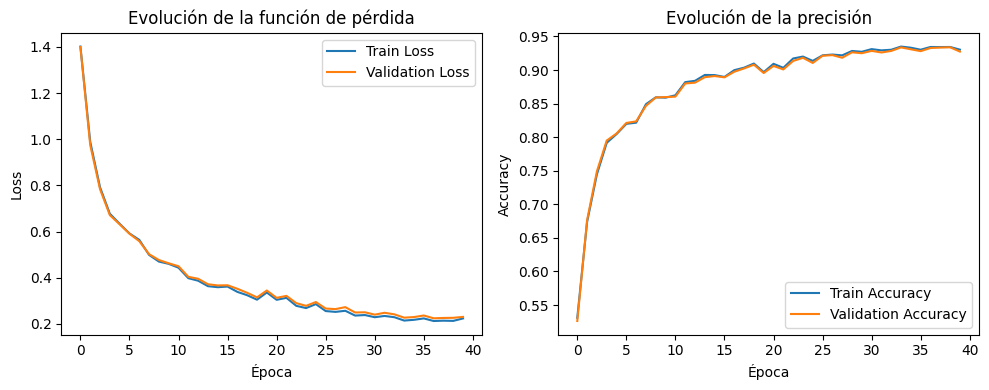

<Figure size 700x700 with 0 Axes>

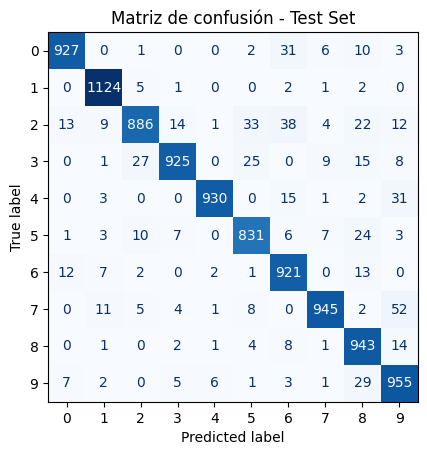

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


class NN(nn.Module):
    def __init__(self, num_classes):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)     # (1,28,28) -> (8,26,26)
        self.conv2 = nn.Conv2d(8, 16, 3)    # (8,13,13) -> (16,11,11)
        self.fc = nn.Linear(16, num_classes)    # 16 -> 10

    def forward(self, x):
        x = F.relu(self.conv1(x))           # (1, 28, 28) -> (8, 26, 26)
        x = F.max_pool2d(x, 2)              # (8, 26, 26) -> (8, 13, 13)
        x = F.relu(self.conv2(x))           # (8, 13, 13) -> (16, 11, 11)
        x = F.adaptive_avg_pool2d(x, 1)     # (16, 11, 11) -> (16, 1, 1)
        x = x.view(x.size(0), -1)           # (16, 1, 1) -> (16)
        x = self.fc(x)                      # (16) -> (10)
        return F.log_softmax(x, dim=1)

# Hiperparámetros
batch_size = 200
num_classes = 10
learning_rate = 5e-3
num_epochs = 500
patience = 3  # para early stopping

# Cargar y dividir datos
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./', train=True, transform=transform, download=True)

# Dividimos el conjunto de entrenamiento (80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

test_dataset = datasets.MNIST(root='./', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Inicialización
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NN(num_classes=num_classes).to(device)
summary(model, input_size=(1, 28, 28))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def evaluate(loader, model):
    """Calcula accuracy y loss en un DataLoader."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            scores = model(data)
            loss = criterion(scores, targets)
            total_loss += loss.item()
            preds = scores.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    avg_loss = total_loss / len(loader)
    acc = correct / total
    model.train()
    return avg_loss, acc

# Entrenamiento + Early Stopping
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calcular métricas al final de la época
    train_loss, train_acc = evaluate(train_loader, model)
    val_loss, val_acc = evaluate(val_loader, model)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}")

    # --- Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict().copy()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping activado en epoch {epoch+1}")
        break

# Restaurar mejor modelo
model.load_state_dict(best_model_state)

# Evaluación final

train_loss, train_acc = evaluate(train_loader, model)
val_loss, val_acc = evaluate(val_loader, model)
test_loss, test_acc = evaluate(test_loader, model)

print("\n--- Resultados finales ---")
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f}")

# Gráficos
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Evolución de la función de pérdida")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Evolución de la precisión")
plt.legend()

plt.tight_layout()
plt.show()

# Matriz de confusión (Test)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        preds = model(data).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
plt.figure(figsize=(7,7))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Matriz de confusión - Test Set")
plt.show()
